In [1]:
!pip install dmslogo
!pip install bottleneck

from google.colab import output
output.clear()

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm
tqdm.pandas()

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import dmslogo

No GPU available


In [3]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

# class utils():
##     @staticmethod
#     def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
#         seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
#         for letterIdx, letter in enumerate(sequence_str):
#             seq_tensor[vocab_list.index(letter), letterIdx] = 1
#         seq_tensor = torch.Tensor(seq_tensor)
#         return seq_tensor

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

# Load CODA library and contributions

In [4]:
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
coda_library_df = boda2_df[row_filter_1 | (boda2_df['method'] == 'fsp') ].reset_index(drop=True)

In [5]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

cell_types = ['K562', 'HepG2', 'SKNSH']

contributions_dicts = {}
for cell_type in cell_types:
  contributions_dicts[cell_type] = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_contributions_{cell_type}.pt')

all_contributions = torch.stack([contributions_dicts[cell_type]['contributions'] for cell_type in cell_types], dim=0)
all_hyp_contributions = torch.stack([contributions_dicts[cell_type]['hyp_contributions'] for cell_type in cell_types], dim=0)

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']

# Processed and hypothetical-contribution core motifs

In [6]:
tensor_motif_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_motif_tensors.pt")
motif_ids = list(tensor_motif_dict.keys())

core_motif_ppms = list(tensor_motif_dict.values())
core_motif_pwms = [ppm_to_pwm(ppm) for ppm in core_motif_ppms]
core_motif_icms = [ppm_to_IC(ppm) for ppm in core_motif_ppms]

core_motif_ppms_rc = [utils.reverse_complement_onehot(ppm) for ppm in core_motif_ppms]
core_motif_pwms_rc = [utils.reverse_complement_onehot(pwm) for pwm in core_motif_pwms]
core_motif_icms_rc = [utils.reverse_complement_onehot(icm) for icm in core_motif_icms]

In [7]:
motif_hyp_scores_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_hyp_scores.pt")

motif_ids = list(motif_hyp_scores_dict.keys())
fwd_motif_hyp_scores = list(motif_hyp_scores_dict.values())
rev_motif_hyp_scores = [utils.reverse_complement_onehot(motif) for motif in fwd_motif_hyp_scores]

In [8]:
# custom_motif_names = ['GATA3', 'ELK4', 'FOSB::JUNB', 'HNF1B', 'HNF4A', 'CREB1', 'RELA', 'SP1', 'TEAD4',
#                       'TP53', 'IRF4', 'STAT1', 'FOXB1', 'NR5A1', 'DBP', 'SOX4', 'SREBF2', 'FOXI1',
#                       'TCF7L1', 'EHF', 'FOXJ2', '*NRF1', 'IRF3', 'NFATC2 x2', 'TYY1', 'NRF1', 'POU3F4', 'MEF2B',
#                       'GFI1B', 'ID4', '*NFIB', 'STREME_1', 'STREME_2', 'MEIS2', 'STREME_4', '*HSF1'
#                       ]

custom_motif_names = ['(GATA3) P0b', '(ELK4) P1', '(FOSB::JUNB) P2', '(HNF1B) P3', '(HNF4A) P4', '(CREB1) P5', '(RELA) P6', '(SP1) P7',
                      '(TEAD4) P10b', '(TP53) P12', '(IRF4) P14', '(STAT1) P15', '(FOXB1) P16', '(NR5A1) P21', '(DBP) P22', '(SOX4) P23b',
                      '(SREBF2) P26', '(FOXI1) P27b', '(TCF7L1) P30', '(EHF) P31', '(FOXJ2) P32b', '(NRF1*) P33', '(IRF3) P34',
                      '(NFATC2x2) P39', '(TYY1) P44', '(NRF1) P46', '(POU3F4) P51b', '(MEF2B) P57b',
                      '(GFI1B) N0', '(ID4) N5', '(NFIB*) N6', 'S1', 'S2', '(MEIS2) S3', 'S4', '(HSF1*) S5'
                      ]

#Load contribution-based motif hits

In [ ]:
contribution_fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_full.tsv', sep='\t')

In [ ]:
# contribution_fimo_df['gradients_pearson'] = pd.to_numeric(contribution_fimo_df['gradients_pearson'])

# # Group by the specified columns and get the index of the maximum 'gradients_pearson' in each group
# idx_max = contribution_fimo_df.groupby(['motif_id', 'motif_alt_id', 'sequence_name', 'start', 'stop', 'strand'])['gradients_pearson'].idxmax()

# # Use the obtained indices to create the sub-dataframe
# fimo_df = contribution_fimo_df.loc[idx_max]

# fimo_df.to_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t', index=None)

fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')

#Drop over-overlapping hits

In [ ]:
%%time
intersection_threshold = 5

fimo_copy = contribution_fimo_df.copy()
fimo_copy.loc[(fimo_copy['start'] < 0), 'start'] = 0
fimo_copy.loc[(fimo_copy['stop'] > 200), 'stop'] = 200

grouped = fimo_copy.sort_values('gradients_pearson', ascending=False).groupby(['sequence_name', 'cell_type'])

count = 0
passing_idxs = []
for name, group in tqdm(grouped):
    global_idxs = group.index.tolist()
    coverage_ranges = [np.arange(start, stop) for start, stop in zip(group.start.tolist(), group.stop.tolist())]

    cover_set = set()
    for global_idx, coverage_range in zip(global_idxs, coverage_ranges):
        if (len(cover_set.intersection(coverage_range)) <= intersection_threshold):
            passing_idxs.append(global_idx)
            cover_set.update(coverage_range)
        else:
            pass

  0%|          | 0/221473 [00:00<?, ?it/s]

CPU times: user 34 s, sys: 912 ms, total: 34.9 s
Wall time: 35.5 s


In [ ]:
minoverlap_contribution_fimo_df = contribution_fimo_df.iloc[sorted(passing_idxs)].reset_index(drop=True)
#minoverlap_contribution_fimo_df.to_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_full_min_overlap.tsv', sep='\t', index=None)

In [ ]:
minoverlap_contribution_fimo_df['gradients_pearson'] = pd.to_numeric(minoverlap_contribution_fimo_df['gradients_pearson'])
idx_max = minoverlap_contribution_fimo_df.groupby(['motif_id', 'motif_alt_id', 'sequence_name', 'start', 'stop', 'strand'])['gradients_pearson'].idxmax()
minoverlap_fimo_df = minoverlap_contribution_fimo_df.loc[idx_max]

#minoverlap_fimo_df.to_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike_min_overlap.tsv', sep='\t', index=None)

#Hits in OL50 sequences (restricted overlapping)

In [ ]:
seq_ids = ['20211206_221956__59439361__2140::al__k562__0',
    '20211206_24503__33072627__1223::al__hepg2__0',
    '20211206_24503__33072627__1816::al__hepg2__0',
    '20211207_100944__255626__132::sa__hepg2__0',
    '20211207_205407__862697__385::sa__k562__0',
    '20211207_63610__124703__1517::sa__hepg2__0',
    '20211212_45907__313665__1548::fsp__hepg2__5',
    '20211212_45907__313665__213::fsp__hepg2__0',
    '20211212_61436__944763__262::fsp__hepg2__0',
    '20211212_85225__619474__1260::fsp__k562__4',
    '20211212_85225__619474__1680::fsp__k562__5',
    '20211212_85225__619474__194::fsp__k562__0',
    '20211212_92818__893131__1479::fsp__k562__4'
                ]

intersection_threshold = 5
cmap = plt.get_cmap('rainbow', len(motif_ids))

color_dict = dict(zip(2 * motif_ids, 2*[cmap(i) for i in range(len(motif_ids))]))

for order_idx, seq_id in enumerate(seq_ids):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    for cell_idx, cell_type in enumerate(cell_types):
        seq_scan_df = contribution_fimo_df[(contribution_fimo_df['sequence_name'] == seq_id) & (contribution_fimo_df['cell_type'] == cell_type)]
        seq_scan_df = seq_scan_df.sort_values('gradients_pearson', ascending=False).reset_index(drop=True)

        seq_contributions = all_contributions[cell_idx, seq_idx, ...]
        y_max = seq_contributions.max()

        find_motif_names  = []
        print_motif_names = []
        motifs_start_ends = []
        orientations      = []
        cover_set         = set()
        num_hits = len(seq_scan_df)
        for i in range(num_hits):
            hit_row = seq_scan_df.iloc[i]
            m_start, m_end = max(0, hit_row['start']), min(200, hit_row['stop'])
            motif_range = set(np.arange(m_start, m_end))
            motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
            pos_contribution = motif_contributions.max()
            neg_contribution = motif_contributions.min()
            contribution_condition = True #(pos_contribution > 0.06) or (neg_contribution < -0.02)
            if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
                find_motif_names.append(hit_row['motif_id'])
                print_motif_names.append(hit_row['motif_alt_id'])
                motifs_start_ends.append((m_start, m_end))
                orientations.append(hit_row['strand'])
                cover_set = cover_set | motif_range
            find_motif_short_names = [name + ' ' + str(strand) for name, strand in zip(find_motif_names, orientations)]
            print_short_names = [name + ' (' + str(strand) + ')' for name, strand in zip(print_motif_names, orientations)]

        matrix_plot = seq_contributions.clone()
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=1.3, fontaspect=0.55)
        for idx, motif_name in enumerate(find_motif_names):
            try:
                color = color_dict[motif_name]
            except:
                color = color_dict[f'{motif_name}b']
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            #text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            text = f'{print_short_names[idx]}'
            x = motifs_start_ends[idx][0]
            y = contrib_min_maxs[idx][1] + 0.05
            plt.text(x, y, text, fontsize=16, rotation=90)
        plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
seq_ids = ['20211206_221956__59439361__2140::al__k562__0',
    '20211206_24503__33072627__1223::al__hepg2__0',
    '20211206_24503__33072627__1816::al__hepg2__0',
    '20211207_100944__255626__132::sa__hepg2__0',
    '20211207_205407__862697__385::sa__k562__0',
    '20211207_63610__124703__1517::sa__hepg2__0',
    '20211212_45907__313665__1548::fsp__hepg2__5',
    '20211212_45907__313665__213::fsp__hepg2__0',
    '20211212_61436__944763__262::fsp__hepg2__0',
    '20211212_85225__619474__1260::fsp__k562__4',
    '20211212_85225__619474__1680::fsp__k562__5',
    '20211212_85225__619474__194::fsp__k562__0',
    '20211212_92818__893131__1479::fsp__k562__4'
                ]

intersection_threshold = 200
cmap = plt.get_cmap('rainbow', len(motif_ids))

color_dict = dict(zip(2 * motif_ids, 2*[cmap(i) for i in range(len(motif_ids))]))

for order_idx, seq_id in enumerate(seq_ids):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    for cell_idx, cell_type in enumerate(cell_types):
        seq_scan_df = minoverlap_contribution_fimo_df[(minoverlap_contribution_fimo_df['sequence_name'] == seq_id) & (minoverlap_contribution_fimo_df['cell_type'] == cell_type)]
        seq_scan_df = seq_scan_df.sort_values('gradients_pearson', ascending=False).reset_index(drop=True)

        seq_contributions = all_contributions[cell_idx, seq_idx, ...]
        y_max = seq_contributions.max()

        find_motif_names  = []
        print_motif_names = []
        motifs_start_ends = []
        orientations      = []
        cover_set         = set()
        num_hits = len(seq_scan_df)
        for i in range(num_hits):
            hit_row = seq_scan_df.iloc[i]
            m_start, m_end = max(0, hit_row['start']), min(200, hit_row['stop'])
            motif_range = set(np.arange(m_start, m_end))
            motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
            pos_contribution = motif_contributions.max()
            neg_contribution = motif_contributions.min()
            contribution_condition = True #(pos_contribution > 0.06) or (neg_contribution < -0.02)
            if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
                find_motif_names.append(hit_row['motif_id'])
                print_motif_names.append(hit_row['motif_alt_id'])
                motifs_start_ends.append((m_start, m_end))
                orientations.append(hit_row['strand'])
                cover_set = cover_set | motif_range
            find_motif_short_names = [name + ' ' + str(strand) for name, strand in zip(find_motif_names, orientations)]
            print_short_names = [name + ' (' + str(strand) + ')' for name, strand in zip(print_motif_names, orientations)]

        matrix_plot = seq_contributions.clone()
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=1.3, fontaspect=0.55)
        for idx, motif_name in enumerate(find_motif_names):
            try:
                color = color_dict[motif_name]
            except:
                color = color_dict[f'{motif_name}b']
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            #text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            text = f'{print_short_names[idx]}'
            x = motifs_start_ends[idx][0]
            y = contrib_min_maxs[idx][1] + 0.05
            plt.text(x, y, text, fontsize=16, rotation=90)
        plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

#Motif hit analyses

In [ ]:
#fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike_min_overlap.tsv', sep='\t')
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')

In [ ]:
natural_methods = ['DHS', 'gs']

num_naturals = coda_library_df['method'].isin(natural_methods).sum()
num_synthetics = coda_library_df['method'].isin(['sa', 'al', 'fsp']).sum()
num_all_seqs = len(coda_library_df)
num_naturals, num_synthetics, num_all_seqs

natural_pcts = []
synthetic_pcts = []
total_pcts = []
for motif_id in tqdm(motif_ids):
    hit_seqs = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    motif_boda2_df = coda_library_df[coda_library_df['ID'].isin(hit_seqs)].reset_index(drop=True)
    motif_num_naturals = motif_boda2_df['method'].isin(natural_methods).sum()
    motif_num_synthetics = motif_boda2_df['method'].isin(['sa', 'al', 'fsp']).sum()
    natural_pcts.append(motif_num_naturals/num_naturals)
    synthetic_pcts.append(motif_num_synthetics/num_synthetics)
    total_pcts.append(len(motif_boda2_df)/num_all_seqs)

  0%|          | 0/36 [00:00<?, ?it/s]

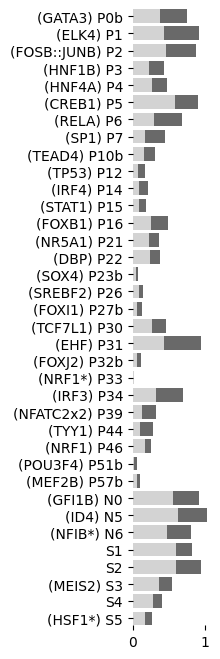

In [ ]:
num_motifs = len(motif_ids)
idx_clustering = np.arange(0, num_motifs) #np.arange(0, num_motifs) #clustered_topic_idxs #clustered_motif_idxs

clustered_motif_labels = np.array(custom_motif_names)[np.ix_(idx_clustering)]
clustered_natural_pcts = np.array(natural_pcts)[np.ix_(idx_clustering)]
clustered_synthetic_pcts = np.array(synthetic_pcts)[np.ix_(idx_clustering)]

plt.figure(figsize=(1,8))
b1 = plt.barh(clustered_motif_labels, clustered_synthetic_pcts, color="lightgray")
b2 = plt.barh(clustered_motif_labels, clustered_natural_pcts, left=clustered_synthetic_pcts, color="dimgray")

#plt.legend([b1, b2], ["Synthetics", "Naturals"], title="Group", fontsize=8, loc='best')
#plt.xlabel('Occurrence percentage', fontsize=12)
plt.gca().invert_yaxis()
plt.margins(y=0)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
#plt.yticks([])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig(f"/content/drive/MyDrive/figures/core_motif_usage.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
#plt.title('Group presence %', y=1.03, fontsize=16)
plt.show()

  0%|          | 0/36 [00:00<?, ?it/s]

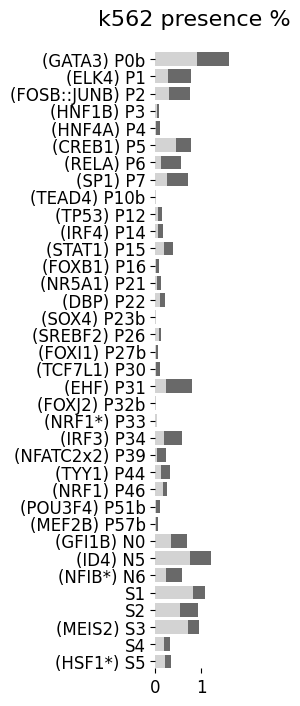

(GATA3) P0b
0.9227647058823529 0.698125
1.3217757649165307

(HNF4A) P4
0.01988235294117647 0.087125
0.22820491180690353

(GFI1B) N0
0.3438823529411765 0.356875
0.9635932831976924

(ID4) N5
0.7631176470588236 0.452
1.6883133784487248

(MEIS2) S3
0.7136470588235294 0.246
2.9010043041606886



  0%|          | 0/36 [00:00<?, ?it/s]

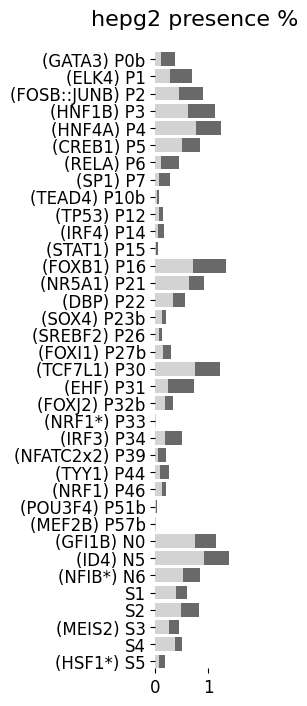

(GATA3) P0b
0.11235294117647059 0.265125
0.4237734697839532

(HNF4A) P4
0.7710588235294118 0.47175
1.6344649147417314

(GFI1B) N0
0.7444705882352941 0.407625
1.8263614553457077

(ID4) N5
0.9160588235294118 0.488125
1.8766890110717784

(MEIS2) S3
0.253 0.191875
1.3185667752442998



  0%|          | 0/36 [00:00<?, ?it/s]

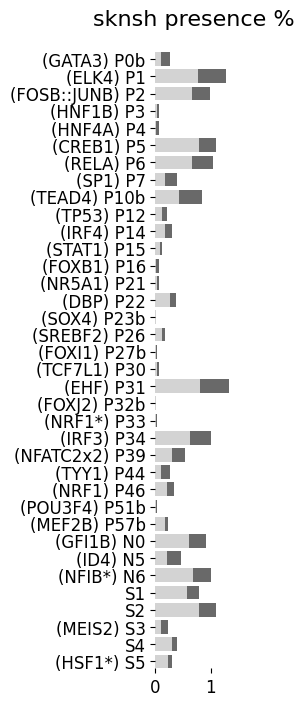

(GATA3) P0b
0.10235294117647059 0.163625
0.6255336359142588

(HNF4A) P4
0.013764705882352941 0.053625
0.25668449197860965

(GFI1B) N0
0.6065294117647059 0.311625
1.946343880512494

(ID4) N5
0.20829411764705882 0.24525
0.8493134256760808

(MEIS2) S3
0.1068235294117647 0.121625
0.8783024000967293



In [ ]:
idx_clustering = np.arange(0, num_motifs) #np.arange(0, num_motifs) #clustered_topic_idxs #clustered_motif_idxs
clustered_motif_labels = np.array(custom_motif_names)[np.ix_(idx_clustering)]

natural_methods = ['DHS', 'gs']
synthetic_methods = ['sa', 'al', 'fsp']

for target_cell in ['k562', 'hepg2', 'sknsh']:
    cell_df = coda_library_df[coda_library_df['target_cell'] == target_cell].reset_index(drop=True)
    cell_num_naturals = cell_df['method'].isin(natural_methods).sum()
    cell_num_synthetics = cell_df['method'].isin(['sa', 'al', 'fsp']).sum()
    cell_num_all_seqs = len(cell_df)

    cell_natural_pcts = []
    cell_synthetic_pcts = []
    cell_total_pcts = []
    for motif_id in tqdm(motif_ids):
        hit_seqs = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
        motif_boda2_df = cell_df[cell_df['ID'].isin(hit_seqs)].reset_index(drop=True)
        motif_num_naturals = motif_boda2_df['method'].isin(natural_methods).sum()
        motif_num_synthetics = motif_boda2_df['method'].isin(synthetic_methods).sum()
        cell_natural_pcts.append(motif_num_naturals/cell_num_naturals)
        cell_synthetic_pcts.append(motif_num_synthetics/cell_num_synthetics)
        cell_total_pcts.append(len(motif_boda2_df)/cell_num_all_seqs)

    clustered_natural_pcts = np.array(cell_natural_pcts)[np.ix_(idx_clustering)]
    clustered_synthetic_pcts = np.array(cell_synthetic_pcts)[np.ix_(idx_clustering)]

    plt.figure(figsize=(1,8))
    b1 = plt.barh(clustered_motif_labels, clustered_synthetic_pcts, color="lightgray")
    b2 = plt.barh(clustered_motif_labels, clustered_natural_pcts, left=clustered_synthetic_pcts, color="dimgray")

    #plt.legend([b1, b2], ["Synthetic", "Natural"], title="Group", fontsize=8)
    #plt.xlabel('Occurrence percentage', fontsize=12)
    plt.gca().invert_yaxis()
    plt.margins(y=0)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    #plt.yticks([])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks([0,1])
    #plt.savefig(f"/content/drive/MyDrive/figures/motif_usage_{target_cell}_revised.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
    plt.title(f'{target_cell} presence %', y=1.03, fontsize=16)
    plt.show()

    for idx in [0, 4, 28, 29, 33]:
        print(custom_motif_names[idx])
        print(cell_synthetic_pcts[idx], cell_natural_pcts[idx])
        print(cell_synthetic_pcts[idx] / cell_natural_pcts[idx])
        print()

In [ ]:
for i, name in enumerate(custom_motif_names):
    print(i, name)

0 (GATA3) P0b
1 (ELK4) P1
2 (FOSB::JUNB) P2
3 (HNF1B) P3
4 (HNF4A) P4
5 (CREB1) P5
6 (RELA) P6
7 (SP1) P7
8 (TEAD4) P10b
9 (TP53) P12
10 (IRF4) P14
11 (STAT1) P15
12 (FOXB1) P16
13 (NR5A1) P21
14 (DBP) P22
15 (SOX4) P23b
16 (SREBF2) P26
17 (FOXI1) P27b
18 (TCF7L1) P30
19 (EHF) P31
20 (FOXJ2) P32b
21 (NRF1*) P33
22 (IRF3) P34
23 (NFATC2x2) P39
24 (TYY1) P44
25 (NRF1) P46
26 (POU3F4) P51b
27 (MEF2B) P57b
28 (GFI1B) N0
29 (ID4) N5
30 (NFIB*) N6
31 S1
32 S2
33 (MEIS2) S3
34 S4
35 (HSF1*) S5


In [ ]:
num_seqs_k562 = (coda_library_df['target_cell'] == 'k562').sum()
num_seqs_hepg2 = (coda_library_df['target_cell'] == 'hepg2').sum()
num_seqs_sknsh = (coda_library_df['target_cell'] == 'sknsh').sum()

k562_pcts = []
hepg2_pcts = []
sknsh_pcts = []
for motif_id in tqdm(motif_ids):
    hit_seqs = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    motif_boda2_df = coda_library_df[coda_library_df['ID'].isin(hit_seqs)].reset_index(drop=True)
    # k562_pcts.append( (motif_boda2_df['target_cell'] == 'k562').sum() / num_all_seqs )
    # hepg2_pcts.append( (motif_boda2_df['target_cell'] == 'hepg2').sum() / num_all_seqs )
    # sknsh_pcts.append( (motif_boda2_df['target_cell'] == 'sknsh').sum() / num_all_seqs )
    k562_pcts.append( (motif_boda2_df['target_cell'] == 'k562').sum() / num_seqs_k562 )
    hepg2_pcts.append( (motif_boda2_df['target_cell'] == 'hepg2').sum() / num_seqs_hepg2 )
    sknsh_pcts.append( (motif_boda2_df['target_cell'] == 'sknsh').sum() / num_seqs_sknsh )

  0%|          | 0/36 [00:00<?, ?it/s]

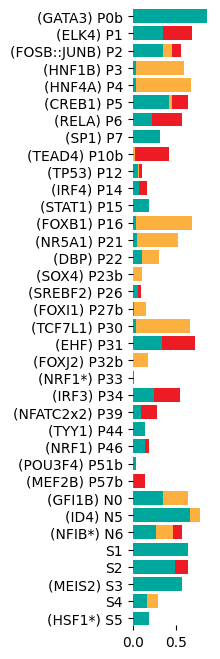

In [ ]:
idx_clustering = np.arange(0, num_motifs) #np.arange(0, num_motifs) #clustered_topic_idxs #clustered_motif_idxs
clustered_motif_labels = np.array(custom_motif_names)[np.ix_(idx_clustering)]

clustered_k562_pcts = np.array(k562_pcts)[np.ix_(idx_clustering)]
clustered_hepg2_pcts = np.array(hepg2_pcts)[np.ix_(idx_clustering)]
clustered_sknsh_pcts = np.array(sknsh_pcts)[np.ix_(idx_clustering)]

plt.figure(figsize=(1,8))
b3 = plt.barh(clustered_motif_labels, clustered_sknsh_pcts, color="#ED1C24")
b2 = plt.barh(clustered_motif_labels, clustered_hepg2_pcts, color="#FBB040")
b1 = plt.barh(clustered_motif_labels, clustered_k562_pcts, color='#00A79D')

#plt.legend([b1, b2], ["Naturals", "Synthetics"], title="Group", fontsize=8)
#plt.xlabel('Enrichment', fontsize=12)
plt.gca().invert_yaxis()
plt.margins(y=0)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
#plt.yticks([])
#plt.xticks([])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)#, color='#002D72')
#plt.savefig(f"/content/drive/MyDrive/figures/motif_target_enrichment.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
#plt.title('Target presence %', y=1.03, fontsize=16)
plt.show()

#Pearson-weighted motif contributions

In [13]:
seq_list = coda_library_df['ID'].tolist()

id2idx_dict = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_contributions = []
for motif_id in tqdm(motif_ids):
    motif_fimo_df = fimo_df[fimo_df['motif_id'] == motif_id]
    motif_starts = motif_fimo_df['start'].tolist()
    motif_stops = motif_fimo_df['stop'].tolist()
    #motif_weights = torch.Tensor((motif_fimo_df['score'] / motif_fimo_df['score'].sum()).to_numpy()).reshape(-1,1)

    motif_seq_ids = motif_fimo_df['sequence_name'].tolist()
    seq_idxs = [id2idx_dict[id] for id in motif_seq_ids]

    weighted_motif_contributions = []
    iterator = zip(seq_idxs, zip(motif_starts, motif_stops))
    for seq_idx, (start, stop) in iterator:
        if start <0 or stop>200:
            pass
        else:
            weighted_motif_contributions.append(all_contributions[:, seq_idx, ..., start:stop])
    motif_weights = torch.Tensor((motif_fimo_df['gradients_pearson'] / motif_fimo_df['gradients_pearson'].sum()).to_numpy()).reshape(-1,1)
    weighted_motif_contributions = torch.stack(weighted_motif_contributions).sum(dim=(2,3)).mean(dim=0)#(torch.stack(weighted_motif_contributions).sum(dim=[2,3]) * motif_weights).sum(dim=0)
    all_motif_contributions.append(weighted_motif_contributions)

all_motif_contributions = torch.stack(all_motif_contributions)

  0%|          | 0/36 [00:00<?, ?it/s]

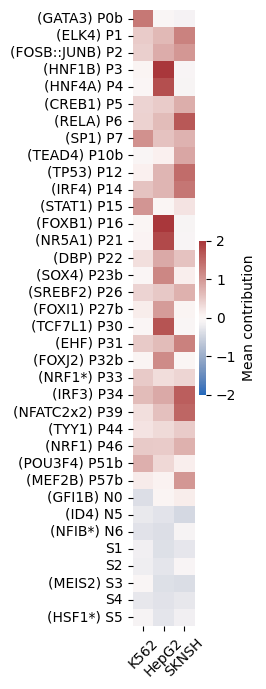

In [ ]:
plt.figure(figsize=(1,8))
sns.heatmap(all_motif_contributions, vmin=-2, vmax=2, cmap="vlag",
            cbar_kws={'label': 'Mean contribution', "shrink": .25})
plt.yticks(np.arange(0, len(custom_motif_names))+0.5, labels=custom_motif_names, rotation=0)
plt.xticks(np.arange(3)+0.5, labels=['K562', 'HepG2', 'SKNSH'], rotation=45)
#plt.title('Weighted mean contribution', y=1.03, fontsize=16)
#plt.savefig(f"/content/drive/MyDrive/figures/core_motif_contributions.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
plt.show()

#Topic assignments

In [ ]:
coloring =  [(0.8352941176470589, 0.0, 1.0, 1.0),
  (0.984313725490196, 0.7058823529411765, 0.6823529411764706, 1.0),
  (0.14901960784313725, 0.5294117647058824, 0.9686274509803922, 1.0),
  (0.7019607843137254, 0.803921568627451, 0.8901960784313725, 1.0),
  (0.8, 0.9215686274509803, 0.7725490196078432, 1.0),
  (1.0, 0.45098039215686275, 0.0, 1.0),
  (0.8705882352941177, 0.796078431372549, 0.8941176470588236, 1.0),
  (0.996078431372549, 0.8509803921568627, 0.6509803921568628, 1.0),
  (1.0, 1.0, 0.8, 1.0),
  (1.0, 0.12156862745098039, 0.5764705882352941, 1.0),
  (0.8980392156862745, 0.8470588235294118, 0.7411764705882353, 1.0),
  (0.788235294117647, 0.3176470588235294, 0.00784313725490196, 1.0)]

#pal = sns.color_palette(coloring.values())
pal = sns.color_palette(coloring)
pal

[(0.8352941176470589, 0.0, 1.0),
 (0.984313725490196, 0.7058823529411765, 0.6823529411764706),
 (0.14901960784313725, 0.5294117647058824, 0.9686274509803922),
 (0.7019607843137254, 0.803921568627451, 0.8901960784313725),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.45098039215686275, 0.0),
 (0.8705882352941177, 0.796078431372549, 0.8941176470588236),
 (0.996078431372549, 0.8509803921568627, 0.6509803921568628),
 (1.0, 1.0, 0.8),
 (1.0, 0.12156862745098039, 0.5764705882352941),
 (0.8980392156862745, 0.8470588235294118, 0.7411764705882353),
 (0.788235294117647, 0.3176470588235294, 0.00784313725490196)]

In [ ]:
nmf = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/Core_motif_topic_modeling/NMF_programs.tsv', sep='\t')

In [ ]:
topic_weights = nmf[motif_ids].to_numpy()
normal_topic_weights = topic_weights / topic_weights.sum(axis=1).reshape(-1,1)

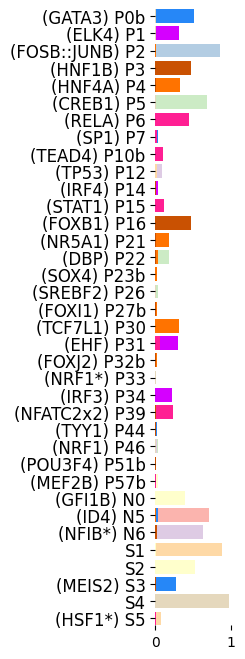

In [ ]:
clustered_motif_labels = custom_motif_names #boda2_streme_tfs['ultimate_id'].to_numpy()[np.ix_(idx_clustering)]
num_topics = topic_weights.shape[0]

#weights = topic_weights / topic_weights.sum(axis=0) #.reshape(1,-1)
#weights = np.log(topic_weights + 1)
weights = normal_topic_weights.copy()
#weights = weights[:, np.ix_(idx_clustering)].reshape(num_topics, -1)
weights = weights.reshape(num_topics, -1)

plt.figure(figsize=(1,8))
for topic_idx in range(num_topics):
    plt.barh(clustered_motif_labels, weights[topic_idx, :], color=pal[topic_idx])

#plt.legend([b1, b2], ["Naturals", "Synthetics"], title="Group", fontsize=16)
#plt.xlabel('Topic assignment', fontsize=12)
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
plt.margins(y=0)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
#plt.xticks([])
#plt.yticks([])
# plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.savefig(f"/content/drive/MyDrive/figures/core_motif_topic_weights.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
plt.show()

# Position-count motifs per method from motif hits

In [ ]:
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')

In [ ]:
motif_fimo_df.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,cell_type,gradients_pearson
197346,pos_core_0b,GATA3,20211206_221956__59439361__0::al__k562__0,54,63,fwd,K562,0.844803
197348,pos_core_0b,GATA3,20211206_221956__59439361__0::al__k562__0,111,120,fwd,K562,0.765187
197349,pos_core_0b,GATA3,20211206_221956__59439361__0::al__k562__0,153,162,fwd,K562,0.839494
197350,pos_core_0b,GATA3,20211206_221956__59439361__1000::al__k562__0,16,25,fwd,K562,0.839006
197354,pos_core_0b,GATA3,20211206_221956__59439361__1001::al__k562__0,58,67,fwd,K562,0.810875


In [ ]:
methods = ['DHS', 'gs', 'sa', 'al', 'fsp']
group_seqs = {}
for method in methods:
    seqs = coda_library_df[(coda_library_df['method'] == method) & (coda_library_df['round'] == 0)]['ID'].tolist()
    group_seqs[method] = seqs

In [ ]:
onehots = onehots_dict['onehots']
seq_list = coda_library_df['ID'].tolist()
id2idx_dict = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_contributions = []
for motif_id in motif_ids:
    for method in methods:
        hit_count = 0
        both_ppms = []
        for strand in ['fwd', 'rev']:
            motif_fimo_df = fimo_df[(fimo_df['motif_id'] == motif_id) & (fimo_df['strand'] == strand)]
            motif_fimo_df = motif_fimo_df[motif_fimo_df['sequence_name'].isin(group_seqs[method])]
            motif_starts = motif_fimo_df['start'].tolist()
            motif_stops = motif_fimo_df['stop'].tolist()

            motif_seq_ids = motif_fimo_df['sequence_name'].tolist()
            seq_idxs = [id2idx_dict[id] for id in motif_seq_ids]

            motif_position_counts = []
            iterator = zip(seq_idxs, zip(motif_starts, motif_stops))
            for seq_idx, (start, stop) in iterator:
                if start <0 or stop>200:
                    pass
                else:
                    motif_position_counts.append(onehots[seq_idx, ..., start:stop])
            pcm = torch.stack(motif_position_counts).sum(dim=0) + 1
            ppm = counts_to_ppm(pcm)
            #icm = ppm_to_IC(ppm)
            both_ppms.append(ppm)
            hit_count += len(seq_idxs)

        combined_ppm = 0.5 * (both_ppms[0] + utils.reverse_complement_onehot(both_ppms[1]))
        combined_icm = ppm_to_IC(combined_ppm)
        matrix_to_dms(combined_icm, y_max=2, heightscale=0.5)
        plt.title(f'{motif_id} - {method} ({hit_count} hits)', fontsize=10)
        plt.show()
    print()

Output hidden; open in https://colab.research.google.com to view.

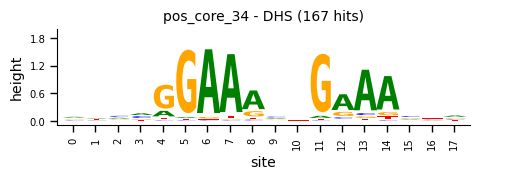

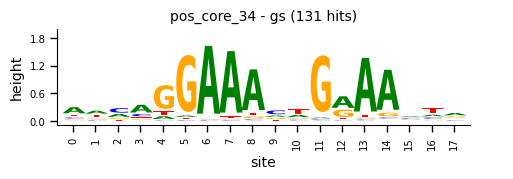

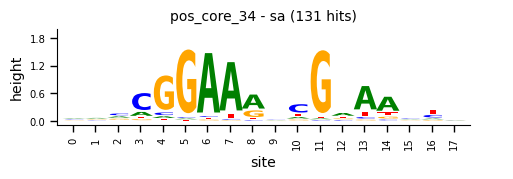

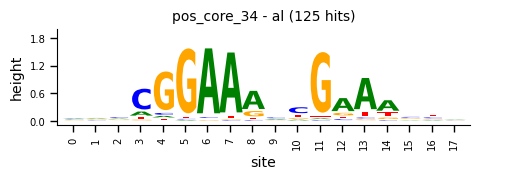

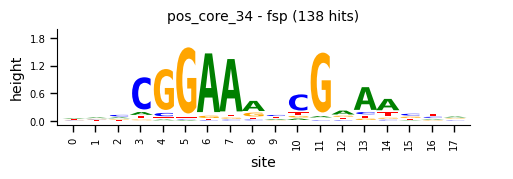

In [ ]:
new_pearson_threshold = 0.65

onehots = onehots_dict['onehots']
seq_list = coda_library_df['ID'].tolist()
id2idx_dict = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_contributions = []
for motif_id in ['pos_core_34']:
    for method in methods:
        hit_count = 0
        both_ppms = []
        for strand in ['fwd', 'rev']:
            motif_fimo_df = fimo_df[(fimo_df['motif_id'] == motif_id) & (fimo_df['strand'] == strand)]
            motif_fimo_df = motif_fimo_df[motif_fimo_df['gradients_pearson'] > new_pearson_threshold]
            motif_fimo_df = motif_fimo_df[motif_fimo_df['sequence_name'].isin(group_seqs[method])]
            motif_starts = motif_fimo_df['start'].tolist()
            motif_stops = motif_fimo_df['stop'].tolist()

            motif_seq_ids = motif_fimo_df['sequence_name'].tolist()
            seq_idxs = [id2idx_dict[id] for id in motif_seq_ids]

            motif_position_counts = []
            iterator = zip(seq_idxs, zip(motif_starts, motif_stops))
            for seq_idx, (start, stop) in iterator:
                if start <0 or stop>200:
                    pass
                else:
                    motif_position_counts.append(onehots[seq_idx, ..., start:stop])
            pcm = torch.stack(motif_position_counts).sum(dim=0) + 1
            ppm = counts_to_ppm(pcm)
            #icm = ppm_to_IC(ppm)
            both_ppms.append(ppm)
            hit_count += len(seq_idxs)

        combined_ppm = 0.5 * (both_ppms[0] + utils.reverse_complement_onehot(both_ppms[1]))
        combined_icm = ppm_to_IC(combined_ppm)
        matrix_to_dms(combined_icm, y_max=2, heightscale=0.5)
        plt.title(f'{motif_id} - {method} ({hit_count} hits)', fontsize=10)
        plt.show()
    print()

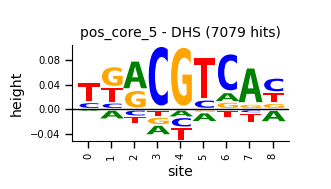

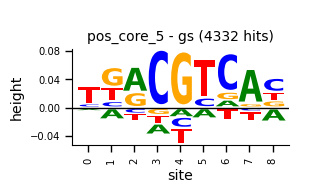

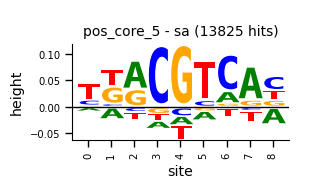

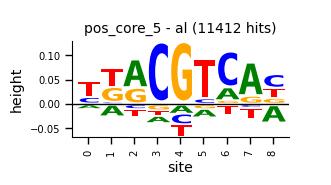

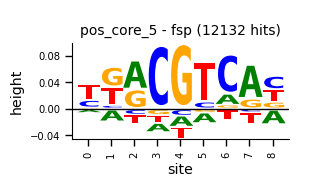

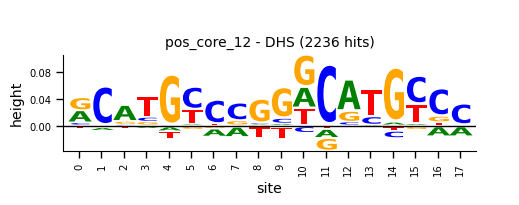

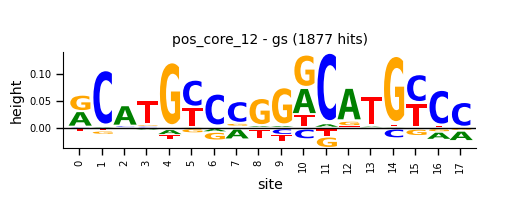

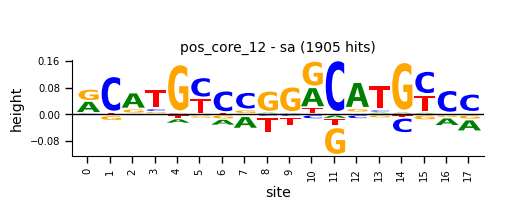

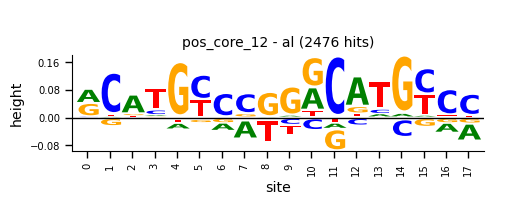

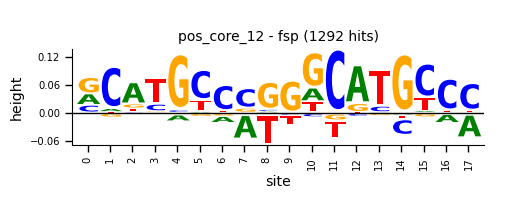

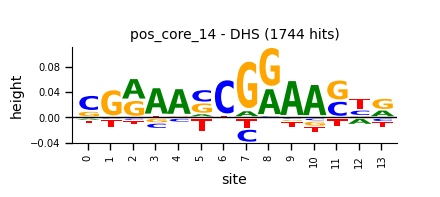

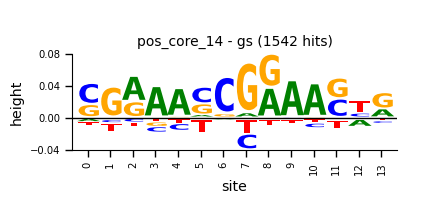

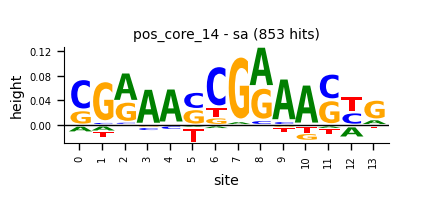

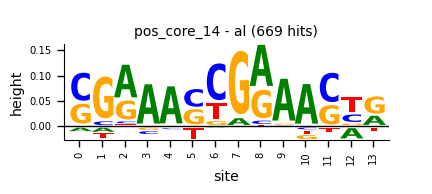

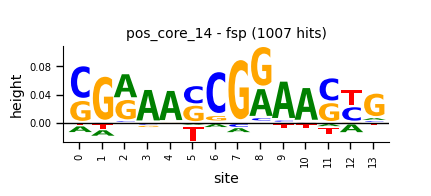

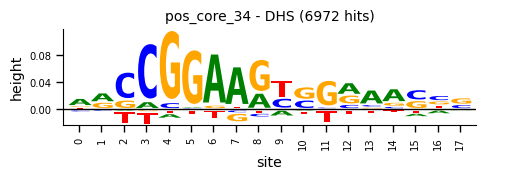

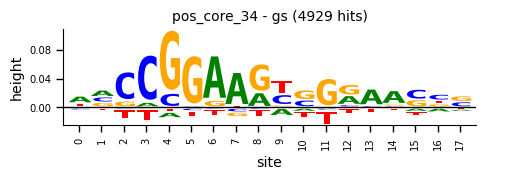

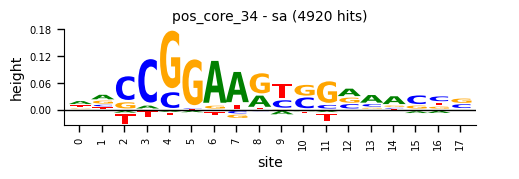

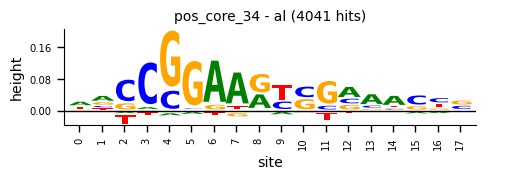

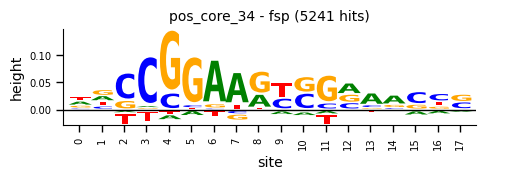

In [ ]:
new_pearson_threshold = 0.65

onehots = onehots_dict['onehots']
seq_list = coda_library_df['ID'].tolist()
id2idx_dict = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_contributions = []
for motif_id in ['pos_core_5', 'pos_core_12', 'pos_core_14', 'pos_core_34']:
    for method in methods:
        hit_count = 0
        both_motif_contribution_patterns = []
        for strand in ['fwd', 'rev']:
            motif_fimo_df = fimo_df[(fimo_df['motif_id'] == motif_id) & (fimo_df['strand'] == strand)]
            #motif_fimo_df = motif_fimo_df[motif_fimo_df['gradients_pearson'] > new_pearson_threshold]
            motif_fimo_df = motif_fimo_df[motif_fimo_df['sequence_name'].isin(group_seqs[method])]
            motif_starts = motif_fimo_df['start'].tolist()
            motif_stops = motif_fimo_df['stop'].tolist()

            motif_seq_ids = motif_fimo_df['sequence_name'].tolist()
            seq_idxs = [id2idx_dict[id] for id in motif_seq_ids]
            cell_idxs = [cell_types.index(cell_type) for cell_type in motif_fimo_df['cell_type'].tolist()]
            match_weights = motif_fimo_df['gradients_pearson'].tolist()

            motif_contribution_pattern = []
            iterator = zip(seq_idxs, zip(motif_starts, motif_stops), cell_idxs, match_weights)
            for seq_idx, (start, stop), cell_idx, match_weight in iterator:
                if start <0 or stop>200:
                    pass
                else:
                    motif_contribution_pattern.append(match_weight * all_contributions[cell_idx, seq_idx, ..., start:stop])

            motif_contribution_pattern = torch.stack(motif_contribution_pattern) #/ np.sum(match_weights)
            mask = (motif_contribution_pattern!=0)
            motif_contribution_pattern = (motif_contribution_pattern * mask).sum(dim=0)/mask.sum(dim=0)
            both_motif_contribution_patterns.append(motif_contribution_pattern)
            hit_count += len(seq_idxs)

        combined_pattern = 0.5 * (both_motif_contribution_patterns[0] + \
                                  utils.reverse_complement_onehot(both_motif_contribution_patterns[1]))
        combined_pattern = torch.nan_to_num(combined_pattern)
        y_max = (combined_pattern * (combined_pattern > 0)).sum(dim=0).max().item()
        matrix_to_dms(combined_pattern, y_max=y_max, heightscale=0.5)
        plt.title(f'{motif_id} - {method} ({hit_count} hits)', fontsize=10)
        plt.show()
    print()

#Co-occurrence

In [9]:
#fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike_min_overlap.tsv', sep='\t')
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')

In [10]:
import bottleneck as bn

def top_n_indexes(arr, n):
    idx = bn.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

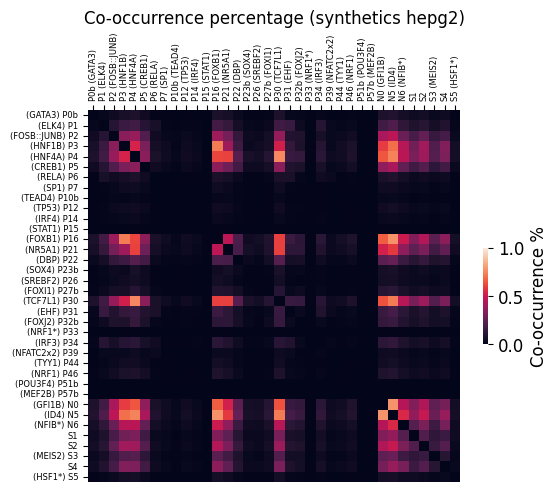

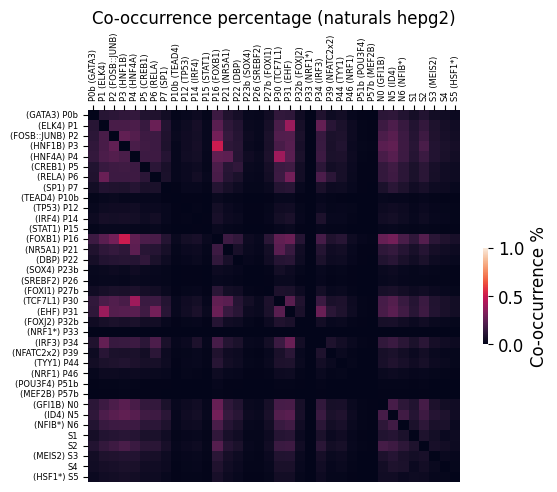

In [40]:
target_cells = ['hepg2'] #['k562', 'hepg2', 'sknsh']

#--- Co-occurrence difference
motif_list = motif_ids.copy()
ultimate_ids = custom_motif_names.copy()
precise_library_df = coda_library_df.copy()
num_motifs = len(ultimate_ids)

flipped_labels = [label.split(' ')[1] + ' ' + label.split(' ')[0] \
                              if (len(label.split(' '))>1) else label.split(' ')[0] for label in custom_motif_names ]

#--- Group 1
methods = ['fsp', 'al', 'sa']
#methods = ['DHS', 'gs']
#methods = ['DHS', 'gs', 'fsp', 'al', 'sa']
 #['k562', 'hepg2', 'sknsh']

group_df = precise_library_df[precise_library_df['method'].isin(methods) & precise_library_df['target_cell'].isin(target_cells)].reset_index(drop=True)
##-For non-penalized
group_df = group_df[group_df['round'].isin([0])].reset_index(drop=True)

for motif_id in tqdm(motif_list):
    motif_seq_set = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    seq_filter = group_df['ID'].isin(motif_seq_set)
    group_df[motif_id] = 0
    group_df.loc[seq_filter, motif_id] = 1

group_df.rename(dict(zip(motif_list, ultimate_ids)), axis=1, inplace=True)
num_seqs_1 = len(group_df)

all_sequence_sets_1 = []
coocurrence_counts = np.zeros((num_motifs, num_motifs))
for i in tqdm(range(num_motifs)):
    row_sequence_sets = []
    for j in range(i+1, num_motifs):
        coocurrence_filter = (group_df[ultimate_ids[i]] == 1) & (group_df[ultimate_ids[j]] == 1)
        seq_ids = group_df[coocurrence_filter]['ID'].tolist()
        coocurrence_counts[i,j] = len(seq_ids)
        row_sequence_sets.append(seq_ids)
    all_sequence_sets_1.append((row_sequence_sets))
coocurrence_pcts = coocurrence_counts / num_seqs_1
coocurrence_pcts = coocurrence_pcts + coocurrence_pcts.T

sorted_coocurrence_1 = coocurrence_pcts #[np.ix_(clustered_motif_idxs, clustered_motif_idxs)]

#--- Group 2
#methods = ['fsp', 'al', 'sa']
methods = ['DHS', 'gs']
#methods = ['DHS']
#methods = ['DHS', 'gs', 'fsp', 'al', 'sa']

group_df = precise_library_df[precise_library_df['method'].isin(methods) & precise_library_df['target_cell'].isin(target_cells)].reset_index(drop=True)

#-For penalized:
# group_df = precise_library_df[precise_library_df['round'].isin([1,2,3,4,5]) & precise_library_df['target_cell'].isin(target_cells)].reset_index(drop=True)
# group_df = group_df[group_df['method'].isin(['fsp'])].reset_index(drop=True)
#---

for motif_id in tqdm(motif_list):
    motif_seq_set = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    seq_filter = group_df['ID'].isin(motif_seq_set)
    group_df[motif_id] = 0
    group_df.loc[seq_filter, motif_id] = 1

group_df.rename(dict(zip(motif_list, ultimate_ids)), axis=1, inplace=True)
num_seqs_2 = len(group_df)

all_sequence_sets_2 = []
coocurrence_counts = np.zeros((num_motifs, num_motifs))
for i in tqdm(range(num_motifs)):
    row_sequence_sets = []
    for j in range(i+1, num_motifs):
        coocurrence_filter = (group_df[ultimate_ids[i]] == 1) & (group_df[ultimate_ids[j]] == 1)
        seq_ids = group_df[coocurrence_filter]['ID'].tolist()
        coocurrence_counts[i,j] = len(seq_ids)
        row_sequence_sets.append(seq_ids)
    all_sequence_sets_2.append((row_sequence_sets))
coocurrence_pcts = coocurrence_counts / num_seqs_2
coocurrence_pcts = coocurrence_pcts + coocurrence_pcts.T

sorted_coocurrence_2 = coocurrence_pcts #[np.ix_(clustered_motif_idxs, clustered_motif_idxs)]

figsize = (6, 5)
all_ticks = np.arange(0, num_motifs) + 0.5
# fit_data = distance_matrix.copy()
# above_distance_matrix = fit_data * (sorted_coocurrence_1 - sorted_coocurrence_2)
# #above_distance_matrix = (sorted_coocurrence_1 - sorted_coocurrence_2)
# # with plt.style.context('fivethirtyeight'):
# #     plt.figure(figsize=figsize)
# #     g = sns.heatmap(above_distance_matrix, square=True, vmin=-0.5, vmax=0.5, cmap="viridis",
# #                     cbar_kws={'label': '', "shrink": .25})
# #     plt.xticks(all_ticks, labels=custom_motif_names, rotation=90, fontsize=6)
# #     plt.yticks(all_ticks, labels=custom_motif_names, rotation=0, fontsize=6)
# #     g.figure.axes[-1].yaxis.label.set_size(12)
# #     g.figure.axes[-1].tick_params(labelsize=12)
# #     g.xaxis.tick_top()
# #     # g.yaxis.tick_right()
# #     plt.grid(False)
# #     plt.title('Co-occurrence weighted by motif distance')

# #     plt.show()

plt.figure(figsize=figsize)
g = sns.heatmap(sorted_coocurrence_1, square=True, vmin=0, vmax=1, cmap="rocket",
                cbar_kws={'label': 'Co-occurrence %', "shrink": .25})
plt.xticks(all_ticks, labels=flipped_labels, rotation=90, fontsize=6)
plt.yticks(all_ticks, labels=custom_motif_names, rotation=0, fontsize=6)
g.figure.axes[-1].yaxis.label.set_size(12)
g.figure.axes[-1].tick_params(labelsize=12)
g.xaxis.tick_top()
# g.yaxis.tick_right()
plt.grid(False)
plt.title('Co-occurrence percentage (synthetics ' + ' '.join(target_cells) + ')')
save_path = f'/content/drive/MyDrive/figures/motif_cooccurrence/core_motif_cooccurrence_raw_{target_cells[0]}_synthetics_v1.pdf'
#plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

plt.figure(figsize=figsize)
g = sns.heatmap(sorted_coocurrence_2, square=True, vmin=0, vmax=1, cmap="rocket",
                cbar_kws={'label': 'Co-occurrence %', "shrink": .25})
plt.xticks(all_ticks, labels=flipped_labels, rotation=90, fontsize=6)
plt.yticks(all_ticks, labels=custom_motif_names, rotation=0, fontsize=6)
g.figure.axes[-1].yaxis.label.set_size(12)
g.figure.axes[-1].tick_params(labelsize=12)
g.xaxis.tick_top()
# g.yaxis.tick_right()
plt.grid(False)
plt.title('Co-occurrence percentage (naturals ' + ' '.join(target_cells) + ')')
save_path = f'/content/drive/MyDrive/figures/motif_cooccurrence/core_motif_cooccurrence_raw_{target_cells[0]}_naturals_v1.pdf'
#plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

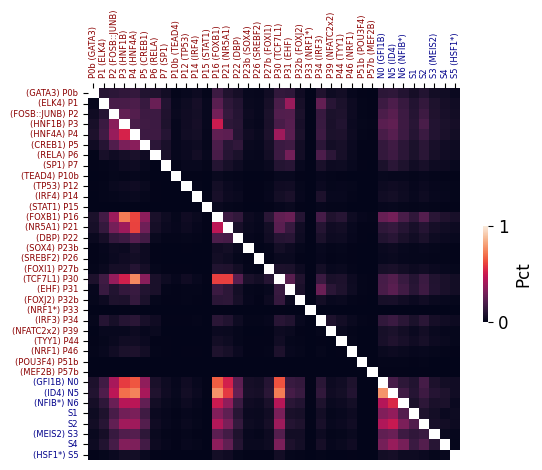

In [41]:
all_ticks = np.arange(0, num_motifs) + 0.5
motif_colors = ['darkred' if (i in pos_idxs) else 'darkblue' for i in range(82)]

plot_matrix_l = sorted_coocurrence_1.copy()
plot_matrix_u = sorted_coocurrence_2.copy()

mask_u = np.zeros_like(plot_matrix_u, dtype=bool)
mask_u[np.triu_indices_from(mask_u)] = True

mask_l = np.zeros_like(plot_matrix_l, dtype=bool)
mask_l[np.tril_indices_from(mask_l)] = True

plot_matrix = mask_l * plot_matrix_l + mask_u * plot_matrix_u

#zeros = np.zeros_like(plot_matrix, dtype=bool)
mask = np.eye(len(motif_ids))

max_color = 1 #np.round(plot_matrix.max(), 2) #0.45 #np.round(plot_matrix.max(), 2)
figsize = (6, 5)

plt.figure(figsize=figsize)
g = sns.heatmap(plot_matrix, square=True, vmin=0, vmax=max_color, cmap="rocket", mask=mask,
                cbar_kws={'label': 'Pct', "shrink": .25, "ticks":[0, max_color]})

flipped_reduced_labels = [label.split(' ')[1] + ' ' + label.split(' ')[0] \
                            if (len(label.split(' '))>1) else label.split(' ')[0] for label in custom_motif_names ]
plt.xticks(all_ticks, labels=flipped_labels, rotation=90, fontsize=6)
plt.yticks(all_ticks, labels=custom_motif_names, rotation=0, fontsize=6)

g.figure.axes[-1].yaxis.label.set_size(12)
g.figure.axes[-1].tick_params(labelsize=12)
g.xaxis.tick_top()
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), motif_colors):
    ticklabel.set_color(tickcolor)
for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), motif_colors):
    ticklabel.set_color(tickcolor)
# g.yaxis.tick_right()
plt.grid(False)
#plt.title('Co-occurrence weighted by motif distance')
save_path = f'/content/drive/MyDrive/figures/motif_cooccurrence/core_motif_cooccurrence_raw_{target_cells[0]}_synth_n_naturals_v1.pdf'
plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

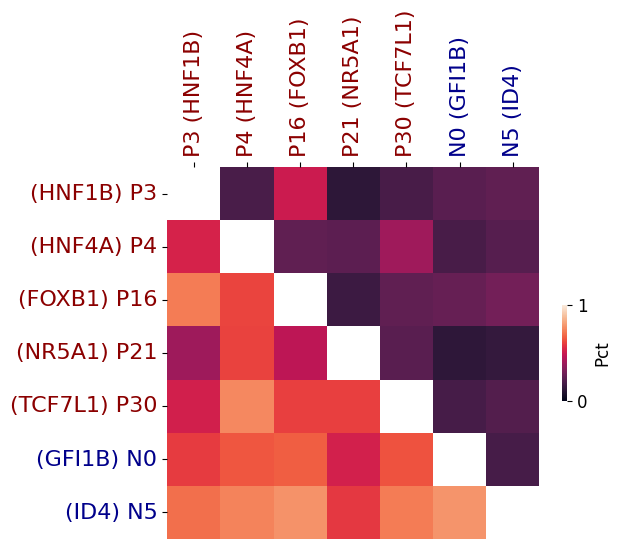

In [42]:
n_top = 10 #20 #50

#---Motif label colors
idx_clustering = np.arange(0, num_motifs) #np.arange(0, num_motifs) #clustered_topic_idxs #clustered_motif_idxs
clustered_motif_labels = np.array(custom_motif_names)[np.ix_(idx_clustering)]

contrib_means = all_motif_contributions.mean(dim=-1)
pos_idxs = torch.where(contrib_means > 0)[0].tolist()
neg_idxs = torch.where(contrib_means <= 0)[0].tolist()
motif_colors = ['darkred' if (i in pos_idxs) else 'darkblue' for i in range(82)]

some_matrix = np.abs(sorted_coocurrence_1 - sorted_coocurrence_2) #fit_data * (sorted_coocurrence_1 - sorted_coocurrence_2)
some_matrix = np.tril(some_matrix)

top_idxs = top_n_indexes(some_matrix, n_top)
top_idxs = sorted(set([item for t in top_idxs for item in t]))

reduced_ticks = np.arange(0.5, len(top_idxs) + 0.5, 1)
reduced_labels = [clustered_motif_labels[j] for j in top_idxs]
reduced_colors = [motif_colors[j] for j in top_idxs]

#---Cooccurrence
plot_matrix_l = (sorted_coocurrence_1)[np.ix_(top_idxs, top_idxs)]
plot_matrix_u = (sorted_coocurrence_2)[np.ix_(top_idxs, top_idxs)]

mask_u = np.zeros_like(plot_matrix_u, dtype=bool)
mask_u[np.triu_indices_from(mask_u)] = True

mask_l = np.zeros_like(plot_matrix_l, dtype=bool)
mask_l[np.tril_indices_from(mask_l)] = True

plot_matrix = mask_l * plot_matrix_l + mask_u * plot_matrix_u

#zeros = np.zeros_like(plot_matrix, dtype=bool)
mask = np.eye(len(top_idxs))

max_color = 1 #np.round(plot_matrix.max(), 2) #0.45 #np.round(plot_matrix.max(), 2)
figsize = (6, 5)
with plt.style.context('fast'):
    plt.figure(figsize=figsize)
    g = sns.heatmap(plot_matrix, square=True, vmin=0, vmax=max_color, cmap="rocket", mask=mask,
                    cbar_kws={'label': 'Pct', "shrink": .25, "ticks":[0, max_color]})

    flipped_reduced_labels = [label.split(' ')[1] + ' ' + label.split(' ')[0] \
                              if (len(label.split(' '))>1) else label.split(' ')[0] for label in reduced_labels ]
    plt.xticks(reduced_ticks, labels=flipped_reduced_labels, rotation=90, fontsize=16)
    plt.yticks(reduced_ticks, labels=reduced_labels, rotation=0, fontsize=16)

    g.figure.axes[-1].yaxis.label.set_size(12)
    g.figure.axes[-1].tick_params(labelsize=12)
    g.xaxis.tick_top()
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), reduced_colors):
        ticklabel.set_color(tickcolor)
    for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), reduced_colors):
        ticklabel.set_color(tickcolor)
    # g.yaxis.tick_right()
    plt.grid(False)
    #plt.title('Co-occurrence weighted by motif distance')
    save_path = f'/content/drive/MyDrive/figures/motif_cooccurrence/core_top{n_top}_motif_cooccurrence_raw_{target_cells[0]}_v1.pdf'
    plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
    plt.show()

#----
# top_idx_set = set(sorted([tuple(sorted(idx_pair)) for idx_pair in top_n_indexes(some_matrix, n_top)]))

# topn_seq_set_1 = []
# topn_seq_set_2 = []
# for idx_pair in top_idx_set:
#     topn_seq_set_1 += all_sequence_sets_1[idx_pair[0]][idx_pair[1] - idx_pair[0] - 1]
#     topn_seq_set_2 += all_sequence_sets_2[idx_pair[0]][idx_pair[1] - idx_pair[0] - 1]

# set_pct_1 = len(set(topn_seq_set_1))/num_seqs_1
# set_pct_2 = len(set(topn_seq_set_2))/num_seqs_2
# print(np.round(100*set_pct_1, 1), np.round(100*set_pct_2, 1))

# global_id_set_1 += list(set(topn_seq_set_1))
# global_id_set_2 += list(set(topn_seq_set_2))

In [ ]:
for idx_pair in [[0,33], [4, 28], [4, 29], [0, 29]]:
    idx_row, idx_col = idx_pair[0], idx_pair[1]
    print(custom_motif_names[idx_row], custom_motif_names[idx_col])
    print(sorted_coocurrence_1[idx_row, idx_col], sorted_coocurrence_2[idx_row, idx_col])
    print()

(GATA3) P0b (MEIS2) S3
0.8918333333333334 0.1785

(HNF4A) P4 (GFI1B) N0
0.00475 0.02975

(HNF4A) P4 (ID4) N5
0.010833333333333334 0.041375

(GATA3) P0b (ID4) N5
0.8489166666666667 0.32225



In [ ]:
contrib_means = all_motif_contributions.mean(dim=-1)
pos_idxs = torch.where(contrib_means > 0)[0].tolist()
neg_idxs = torch.where(contrib_means <= 0)[0].tolist()

pos_neg_pairs = []
for pos_i in pos_idxs:
    for neg_j in neg_idxs:
        pos_neg_pairs.append(tuple(sorted([pos_i, neg_j])))
pos_neg_pairs = list(set(pos_neg_pairs))

pos_pos_pairs = []
for pos_i in pos_idxs:
    for pos_j in pos_idxs:
        if pos_i != pos_j:
            pos_pos_pairs.append(tuple(sorted([pos_i, pos_j])))
pos_pos_pairs = list(set(pos_pos_pairs))

neg_neg_pairs = []
for neg_i in neg_idxs:
    for neg_j in neg_idxs:
        if neg_i != neg_j:
            neg_neg_pairs.append(tuple(sorted([neg_i, neg_j])))
neg_neg_pairs = list(set(neg_neg_pairs))

len(pos_neg_pairs), len(pos_pos_pairs), len(neg_neg_pairs)

(224, 378, 28)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

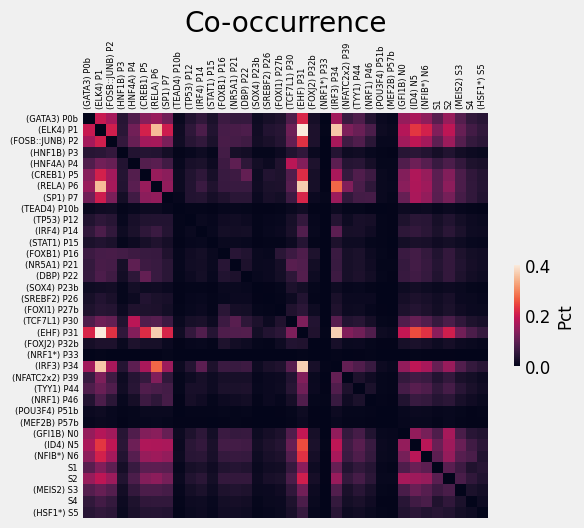

In [ ]:
#--- Co-occurrence
idx_clustering = np.arange(0, num_motifs)
# clustered_motif_labels = boda2_streme_tfs['ultimate_id'].to_numpy()[np.ix_(idx_clustering)]

# motif_list = boda2_streme_tfs['motif_id'].tolist()
# ultimate_ids = boda2_streme_tfs['ultimate_id']
figsize = (6, 5)

#methods = ['fsp', 'al', 'sa']
#methods = ['DHS', 'gs']
#methods = ['gs']
methods = ['DHS']
#methods = ['DHS', 'gs', 'fsp', 'al', 'sa']
target_cells = ['k562', 'hepg2', 'sknsh'] #['k562', 'hepg2', 'sknsh']

group_df = precise_library_df[precise_library_df['method'].isin(methods) & precise_library_df['target_cell'].isin(target_cells)].reset_index(drop=True)
#-For non-penalized
#group_df = group_df[group_df['round'].isin([0])].reset_index(drop=True)
#-For penalized
#group_df = group_df[group_df['round'] != 0].reset_index(drop=True)

for motif_id in tqdm(motif_list):
    motif_seq_set = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    seq_filter = group_df['ID'].isin(motif_seq_set)
    group_df[motif_id] = 0
    group_df.loc[seq_filter, motif_id] = 1

group_df.rename(dict(zip(motif_list, ultimate_ids)), axis=1, inplace=True)
num_seqs = len(group_df)

all_sequence_sets = []
coocurrence_counts = np.zeros((num_motifs, num_motifs))
for i in tqdm(range(num_motifs)):
    row_sequence_sets = []
    for j in range(i+1, num_motifs):
        coocurrence_filter = (group_df[ultimate_ids[i]] == 1) & (group_df[ultimate_ids[j]] == 1)
        seq_ids = group_df[coocurrence_filter]['ID'].tolist()
        coocurrence_counts[i,j] = len(seq_ids)
        row_sequence_sets.append(seq_ids)
    all_sequence_sets.append((row_sequence_sets))
coocurrence_pcts = coocurrence_counts / num_seqs
coocurrence_pcts = coocurrence_pcts + coocurrence_pcts.T

sorted_coocurrence = coocurrence_pcts[np.ix_(idx_clustering, idx_clustering)]

# with plt.style.context('fivethirtyeight'):
#     plt.figure(figsize=figsize)
#     g = sns.heatmap(sorted_coocurrence, square=True, vmin=0, vmax=0.15,
#                     cbar_kws={'label': 'Pct', "shrink": .25})
#     plt.xticks(all_ticks, labels=clustered_motif_labels, rotation=90, fontsize=6)
#     plt.yticks(all_ticks, labels=clustered_motif_labels, rotation=0, fontsize=6)
#     g.figure.axes[-1].yaxis.label.set_size(12)
#     g.figure.axes[-1].tick_params(labelsize=12)
#     g.xaxis.tick_top()
#     # g.yaxis.tick_right()
#     plt.grid(False)
#     plt.title('Co-occurrence pcts')

#     plt.show()


with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=figsize)
    g = sns.heatmap(sorted_coocurrence, square=True, vmin=0, vmax=0.4, #cmap="viridis",
                    cbar_kws={'label': 'Pct', "shrink": .25})
    plt.xticks(all_ticks, labels=clustered_motif_labels, rotation=90, fontsize=6)
    plt.yticks(all_ticks, labels=clustered_motif_labels, rotation=0, fontsize=6)
    g.figure.axes[-1].yaxis.label.set_size(12)
    g.figure.axes[-1].tick_params(labelsize=12)
    g.xaxis.tick_top()
    # g.yaxis.tick_right()
    plt.grid(False)
    plt.title('Co-occurrence')

    plt.show()

In [ ]:
seq_set = []
for idx_pair in pos_neg_pairs:
    if idx_pair[1] == idx_pair[0]:
        pass
    else:
        seq_set += all_sequence_sets[idx_pair[0]][idx_pair[1] - idx_pair[0] - 1]
print(len(set(seq_set))/num_seqs)

seq_set = []
for idx_pair in pos_pos_pairs:
    seq_set += all_sequence_sets[idx_pair[0]][idx_pair[1] - idx_pair[0] - 1]
print(len(set(seq_set))/num_seqs)

seq_set = []
for idx_pair in neg_neg_pairs:
    seq_set += all_sequence_sets[idx_pair[0]][idx_pair[1] - idx_pair[0] - 1]
print(len(set(seq_set))/num_seqs)

0.9215
0.966
0.7056666666666667


In [ ]:
'''
Non-penalized synthetics:
pos/neg: 0.9993611111111111
pos/pos: 0.9568611111111112
neg/neg: 0.9888055555555556

Malinois-natural:
pos/neg: 0.831
pos/pos: 0.9389166666666666
neg/neg: 0.5755

DHS-natural:
pos/neg: 0.9215
pos/pos: 0.966
neg/neg: 0.7056666666666667

All synthetics:
pos/neg: 0.9945294117647059
pos/pos: 0.966
neg/neg: 0.9571960784313726

All naturals:
pos/neg: 0.87625
pos/pos: 0.9524583333333333
neg/neg: 0.6405833333333333

Penalized synthetics:
pos/neg: 0.9829333333333333
pos/pos: 0.9879333333333333
neg/neg: 0.8813333333333333
'''

#Type/token

In [ ]:
matches = fimo_df.groupby('sequence_name').motif_id.apply(list).reset_index()
matches.rename({'sequence_name':'ID'}, axis=1, inplace=True)

In [ ]:
matches_df = matches.merge(coda_library_df, on='ID', how='inner')

matches_df['token'] = matches_df.progress_apply(lambda x: len(x['motif_id']), axis=1)
matches_df['type'] = matches_df.progress_apply(lambda x: len(set(x['motif_id'])), axis=1)

matches_df['type/token'] = matches_df['type'] / matches_df['token']

  0%|          | 0/74991 [00:00<?, ?it/s]

  0%|          | 0/74991 [00:00<?, ?it/s]

In [ ]:
dhs_annotation_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/satellite_repeat_annotations/DHS.Control.Satellite.Simple.Repeats.txt', sep='\t')
mal_annotation_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/satellite_repeat_annotations/Malinois.Natural.Satellite.Simple.Repeats.txt', sep='\t')

dhs_annotation_df['Seq ID'] = [x[0] for x in dhs_annotation_df['Seq ID'].str.split(':')]
mal_annotation_df['Seq ID'] = [(':').join(x[:2]) for x in mal_annotation_df['Seq ID'].str.split(':').tolist()]

repetitive_seqs = set(dhs_annotation_df['Seq ID'].tolist() + mal_annotation_df['Seq ID'].tolist())

In [ ]:
row_filter = matches_df['method'].isin(['DHS', 'gs'])
truncated_ids = [x[0] for x in matches_df.loc[row_filter]['ID'].str.split('::').tolist()]
matches_df.loc[row_filter, 'truncated_id'] = truncated_ids

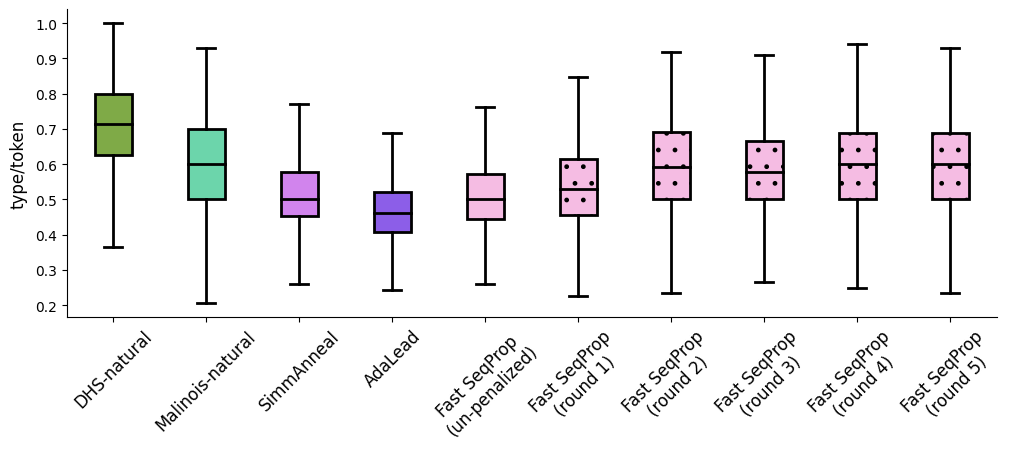

In [ ]:
# xtick_labels = ['DHS-natural\n(non-repetitive)', 'Malinois-natural\n(non-repetitive)', 'SimmAnneal', 'AdaLead', 'Fast SeqProp\n(un-penalized)',
#                        'Fast SeqProp\n(round 1)', 'Fast SeqProp\n(round 2)', 'Fast SeqProp\n(round 3)', 'Fast SeqProp\n(round 4)', 'Fast SeqProp\n(round 5)']
xtick_labels = ['DHS-natural', 'Malinois-natural', 'SimmAnneal', 'AdaLead', 'Fast SeqProp\n(un-penalized)',
                       'Fast SeqProp\n(round 1)', 'Fast SeqProp\n(round 2)', 'Fast SeqProp\n(round 3)',
                'Fast SeqProp\n(round 4)', 'Fast SeqProp\n(round 5)']

conditon_1 = matches_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (matches_df['round'] == 0)
condition_2 = matches_df['method'] == 'fsp'
plot_df = matches_df[conditon_1 | condition_2].reset_index(drop=True)

#plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)

row_filter = plot_df['method'] == 'fsp'
plot_df.loc[row_filter, 'method'] = 'Fast SeqProp\nround ' + plot_df[row_filter]['round'].astype(str)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order = ['DHS', 'gs', 'sa', 'al', 'Fast SeqProp\nround 0', 'Fast SeqProp\nround 1',
       'Fast SeqProp\nround 2', 'Fast SeqProp\nround 3',
       'Fast SeqProp\nround 4', 'Fast SeqProp\nround 5']
ordered_colors = ['#81BA37', '#5AE7AE', '#D972FF', '#8447FF'] + 6*['#FFB2E6']
hatches = 5*[''] + 5*['.']
with plt.style.context('fast'):
    plt.figure(figsize=(12,4))
    mpl.rcParams['lines.linewidth'] = 2.0
    g = sns.boxplot(data=plot_df, x='method', y='type/token', showfliers=False, order=order, width=0.4, palette=ordered_colors, **PROPS)
    patches = [patch for patch in g.patches if type(patch) == mpl.patches.PathPatch]
    h = hatches * (len(patches) // len(hatches))
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        patch.set_edgecolor('k')
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    plt.xlabel('')
    g.set_xticklabels(xtick_labels, fontsize=12, rotation=45)
    plt.ylabel('type/token', labelpad=5, fontsize=12)
    savepath = f'/content/drive/MyDrive/figures/type_token/core_type_token_all_methods_boxplot.pdf'
    #plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
    plt.show()

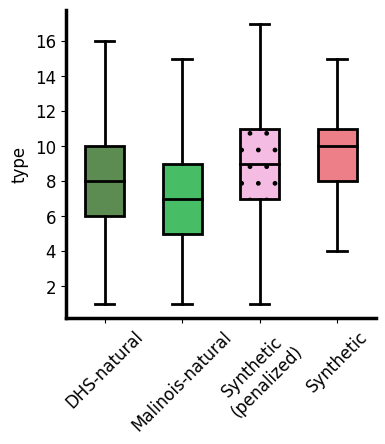

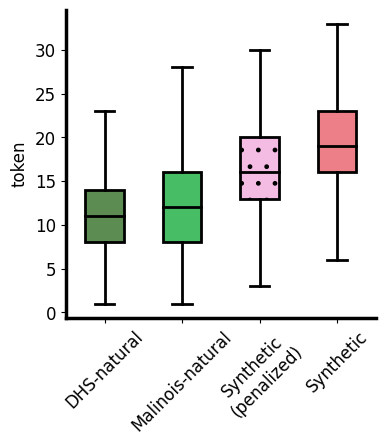

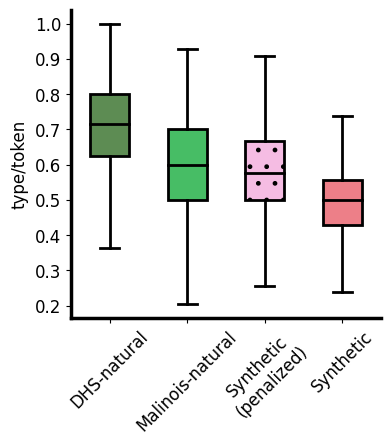

In [ ]:
cell_types = ['K562', 'HepG2', 'SKNSH']
target_cells = ['k562', 'hepg2', 'sknsh']
#colors = ['dimgray', 'darkgray', 'lightgrey', 'lightgrey' ]

color_dict = {
  'penalized': '#FFB2E6',
  'gradient': '#FFB2E6',
  'probabilistic': '#D972FF',
  'evolutionary': '#8447FF',
  'Malinois_natural': '#33D15B',
  'DHS_natural': '#57954A',
  'all_naturals': '#5B9EDD',
  'all_synthetics': '#FF6D79',
}
colors = [color_dict['DHS_natural'], color_dict['Malinois_natural'], color_dict['gradient'], color_dict['all_synthetics']]

plot_df = matches_df.copy()
#plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)

dhs_rows = plot_df['method'].isin(['DHS'])
plot_df.loc[dhs_rows, 'origin_tag'] = 'DHS'

gs_rows = plot_df['method'].isin(['gs'])
plot_df.loc[gs_rows, 'origin_tag'] = 'Genome scan'

synth_penalized = plot_df['method'].isin(['fsp']) & (plot_df['round'] != 0)
#synth_penalized = plot_df['method'].isin(['sa_rep'])                                       #Compare sa_rep
plot_df.loc[synth_penalized, 'origin_tag'] = 'Synthetic (penalized)'

synth_non_penalized = plot_df['method'].isin(['al', 'sa', 'fsp']) & (plot_df['round'] == 0)
#synth_non_penalized = plot_df['method'].isin(['sa'])                                        #Compare sa_rep
plot_df.loc[synth_non_penalized, 'origin_tag'] = 'Synthetic'

order = ['DHS', 'Genome scan', 'Synthetic (penalized)', 'Synthetic']
# quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
# plot_df = plot_df[quality_filter].reset_index(drop=True)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

hatches = ['', '', '.', '']
for column in ['type', 'token', 'type/token']:
# for target_cell in target_cells:
#     temp_plot_df = plot_df[plot_df['target_cell'] == target_cell].reset_index(drop=True)
    temp_plot_df = plot_df.copy()
    with plt.style.context('fast'):
        #mpl.rc('axes',edgecolor='#002D72')
        mpl.rcParams['lines.linewidth'] = 2.0
        plt.figure(figsize=(4,4))
        g = sns.boxplot(data=temp_plot_df, x='origin_tag', y=column, #k_depth='full',
                        order=order, palette=colors, width=0.5,
                        showfliers=False, **PROPS
                        )
        patches = [patch for patch in g.patches if type(patch) == mpl.patches.PathPatch]
        h = hatches * (len(patches) // len(hatches))
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            patch.set_edgecolor('k')
        #g.set(xticklabels=[])
        plt.xlabel('')
        #plt.xticks([])
        #plt.ylabel('')
        plt.yticks(fontsize=12)#, color='#002D72')
        for _,s in g.spines.items():
            s.set_linewidth(2.5)
            #s.set_color('#002D72')
        #plt.ylim(-6.5, 9)
        plt.ylabel(column, labelpad=5, fontsize=12)
        #plt.title(target_cell, fontsize=18, y=1.05)
        #plt.xlabel("", labelpad=10)
        #g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'Synthetic'], fontsize=16)
        #g.set_xticklabels(['DHS-natural\n(non-repetitive)', 'Malinois-natural\n(non-repetitive)', 'Synthetic\n(penalized)', 'Synthetic'], fontsize=12, rotation=45)
        g.set_xticklabels(['DHS-natural', 'Malinois-natural', 'Synthetic\n(penalized)', 'Synthetic'], fontsize=12, rotation=45)

        #g.set_xticklabels(['DHS', 'Genome scan', 'SA (rep)', 'SA'], fontsize=16)                   #Compare sa_rep
        #plt.xticks(rotation=50)
        g.spines['top'].set_visible(False)
        g.spines['right'].set_visible(False)
        #g.spines['left'].set_visible(False)

        flat_column = column.replace('/', '_')
        savepath = f'/content/drive/MyDrive/figures/type_token/core_{flat_column}_boxplots.pdf'
        #plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
        plt.show()

In [ ]:
methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
plot_df = matches_df[matches_df['method'].isin(methods) & (matches_df['round'] == 0)].reset_index(drop=True)

#plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)

synthetics_df = plot_df[plot_df['method'].isin(['fsp', 'sa', 'al'])].reset_index(drop=True)
naturals_df = plot_df[plot_df['method'].isin(['DHS', 'gs'])].reset_index(drop=True)

type_pvalue = stats.ranksums(synthetics_df['type'].to_numpy(), naturals_df['type'].to_numpy(), alternative='greater', nan_policy='omit')
token_pvalue = stats.ranksums(synthetics_df['token'].to_numpy(), naturals_df['token'].to_numpy(), alternative='greater', nan_policy='omit')

print(type_pvalue)
print(token_pvalue)
print()
print(synthetics_df['type'].median() / naturals_df['type'].median())
print(synthetics_df['token'].median() / naturals_df['token'].median())
# print()
# print(synthetics_df['type'].mean() / naturals_df['type'].mean())
# print(synthetics_df['token'].mean() / naturals_df['token'].mean())
print()
print(synthetics_df['type'].median() - naturals_df['type'].median())
print(synthetics_df['token'].median() - naturals_df['token'].median())
# print()
# print(synthetics_df['type'].mean() - naturals_df['type'].mean())
# print(synthetics_df['token'].mean() - naturals_df['token'].mean())

RanksumsResult(statistic=77.79635268250077, pvalue=0.0)
RanksumsResult(statistic=147.44810921140618, pvalue=0.0)

1.25
1.5833333333333333

2.0
7.0


In [ ]:
methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
plot_df = matches_df[matches_df['method'].isin(methods)].reset_index(drop=True)

#plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)

synthetics_df = plot_df[plot_df['method'].isin(['fsp', 'sa', 'al']) & (plot_df['round'] == 0)].reset_index(drop=True)
synthetics_penal_df = plot_df[plot_df['method'].isin(['fsp']) & (plot_df['round'] != 0)].reset_index(drop=True)
naturals_df = plot_df[plot_df['method'].isin(['DHS', 'gs'])].reset_index(drop=True)

type_pvalue = stats.ranksums(synthetics_penal_df['type'].to_numpy(), naturals_df['type'].to_numpy(), alternative='greater', nan_policy='omit')
token_pvalue = stats.ranksums(synthetics_penal_df['token'].to_numpy(), naturals_df['token'].to_numpy(), alternative='greater', nan_policy='omit')
syn_type_token_pvalue = stats.ranksums(synthetics_penal_df['type/token'].to_numpy(), synthetics_df['type/token'].to_numpy(), alternative='greater', nan_policy='omit')

print(type_pvalue)
print(token_pvalue)
print()
print(synthetics_penal_df['type'].median() / naturals_df['type'].median())
print(synthetics_penal_df['token'].median() / naturals_df['token'].median())
# print()
# print(synthetics_df['type'].mean() / naturals_df['type'].mean())
# print(synthetics_df['token'].mean() / naturals_df['token'].mean())
print()
print(synthetics_penal_df['type'].median() - naturals_df['type'].median())
print(synthetics_penal_df['token'].median() - naturals_df['token'].median())
print()
print(syn_type_token_pvalue)
print(synthetics_penal_df['type/token'].median(), synthetics_df['type/token'].median())

RanksumsResult(statistic=49.99287389808356, pvalue=0.0)
RanksumsResult(statistic=77.01868103194553, pvalue=0.0)

1.125
1.3333333333333333

1.0
4.0

RanksumsResult(statistic=70.33376754160915, pvalue=0.0)
0.5769230769230769 0.5


#Contribution coverage

In [ ]:
def vrange(starts, stops):
    stops = np.asarray(stops)
    l = stops - starts # Lengths of each range.
    return np.repeat(stops - l.cumsum(), l) + np.arange(l.sum())

In [ ]:
#fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')

fimo_df.loc[(fimo_df['start'] < 0), 'start'] = 0
fimo_df.loc[(fimo_df['stop'] > 200), 'stop'] = 200

In [ ]:
starts = fimo_df.groupby('sequence_name').start.apply(list).reset_index()
stops = fimo_df.groupby('sequence_name').stop.apply(list).reset_index()

stops = stops['stop'].tolist()
starts = starts['start'].tolist()

abs_flat_contribution_tensor = all_contributions.sum(dim=2).abs()

In [ ]:
fimo_df.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,gradients_pearson
0,streme_cluster__8_19_44,STREME_2,20211212_73316__958155__1619::fsp__sknsh__5,35,46,rev,0.901676
1,streme_cluster__8_19_44,STREME_2,20211207_152258__777391__1814::sa__sknsh__0,182,193,fwd,0.901186
2,streme_cluster__8_19_44,STREME_2,20211206_221956__59439361__3318::al__k562__0,172,183,rev,0.898860
3,streme_cluster__8_19_44,STREME_2,20211212_73316__958155__378::fsp__sknsh__0,34,45,fwd,0.898667
4,streme_cluster__8_19_44,STREME_2,20211212_10357__323391__1975::fsp__k562__0,106,117,fwd,0.898201


In [ ]:
seq_id_list = fimo_df['sequence_name'].drop_duplicates(keep='first').tolist()
num_sequences = len(coda_library_df)

all_covered_contributions = []
for cell_idx in range(3):
    covered_contributions = []
    #for seq_idx in tqdm(range(num_sequences)):
    for fimo_seq_idx, seq_id in enumerate(tqdm(seq_id_list)):
        seq_starts = starts[fimo_seq_idx]
        seq_stops = stops[fimo_seq_idx]
        idxs_covered = np.unique(vrange(seq_starts, seq_stops))
        coda_seq_idx = coda_library_df[coda_library_df['ID'] == seq_id].index.item()
        covered_contributions.append(abs_flat_contribution_tensor[cell_idx, coda_seq_idx, idxs_covered].sum().item())

    all_covered_contributions.append(torch.Tensor(covered_contributions))

all_covered_contributions = torch.stack(all_covered_contributions)

  0%|          | 0/74991 [00:00<?, ?it/s]

  0%|          | 0/74991 [00:00<?, ?it/s]

  0%|          | 0/74991 [00:00<?, ?it/s]

In [ ]:
fimo_seq_idxs = coda_library_df[coda_library_df['ID'].isin(seq_id_list)].index.tolist()
covered_pcts = all_covered_contributions / (abs_flat_contribution_tensor[:, fimo_seq_idxs, :].sum(dim=-1) + 1e-6)
print(covered_pcts.mean(dim=-1))
print(covered_pcts.mean(dim=-1).mean())

tensor([0.6916, 0.6610, 0.7211])
tensor(0.6912)


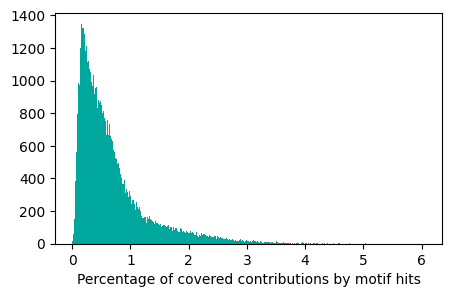

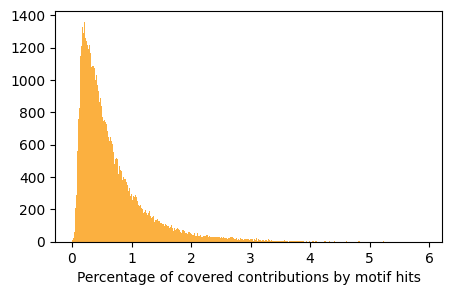

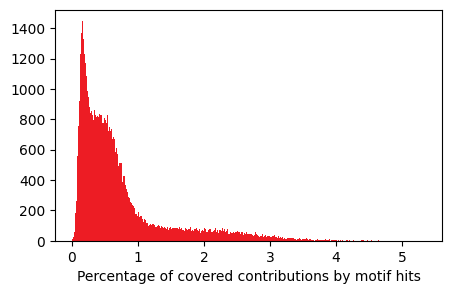

In [ ]:
cell_colors = ['#00A79D', '#FBB040', '#ED1C24']

# with plt.style.context('fivethirtyeight'):
for cell_idx in range(3):
    plt.figure(figsize=(5,3))
    plt.hist(covered_pcts[cell_idx,...].numpy(), bins=500, color=cell_colors[cell_idx])
    plt.xlabel('Percentage of covered contributions by motif hits')
    plt.show()

# Generate test set fasta

In [ ]:
ukbb_gtex_df = pd.read_csv('/content/drive/MyDrive/data/BODA/MPRA_ALL_no_cutoffs_v2_pred.txt', sep=" ", low_memory=False)
ukbb_gtex_df['seq_len'] = ukbb_gtex_df.apply(lambda x: len(x['nt_sequence']), axis=1)

#temp_df = ukbb_gtex_df[ukbb_gtex_df['chr'].isin(['7', '13']) & (ukbb_gtex_df['seq_len'] == 200)].reset_index(drop=True)
temp_df = ukbb_gtex_df[ukbb_gtex_df['chr'].isin(['7', '13'])].reset_index(drop=True)

#fasta_file_path = '/content/drive/MyDrive/data/BODA/CODA__test_set_200.fa'
fasta_file_path = '/content/drive/MyDrive/data/BODA/CODA__test_set.fa'

with open(fasta_file_path, 'w') as fasta_file:
    for index, row in temp_df[['IDs', 'nt_sequence']].iterrows():
        fasta_file.write(f'>{row["IDs"]}\n{row["nt_sequence"]}\n')